# Rahnama College Machine Learning Internship: Spring 1400
For the given dataset, we will use the two famous APIs, Fastai and Keras to predict whether a created task is fake or not. Next, we compare accuracies of the two models.

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from os.path import join
base_dir = '/content/gdrive/My Drive/Rahnama College/'

In [ ]:
import zipfile
with zipfile.ZipFile(join(base_dir, 'Dataset.zip'), 'r') as zip_ref:
    zip_ref.extractall(base_dir)

## Dataset Overview

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(join(base_dir, 'dataset.csv'))
df.head(10)

,id,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,TaskState,TargetProId,isFraud
0,VkSa32MyS738HMkfk4tEfk,vqUkxUDuEmB7gHWQvcYrBn,1.552750e+12,SgcxJApdnttAvEN9865TSZ,1.565440e+12,5,1.565610e+12,362000.0,bKv8JeCDhHBCe8SnfDcv66,VzkJEPR5H3mnqctJ8TW3YS,98DpwFpuLYJtF6jajghriE,Finished,vqUkxUDuEmB7gHWQvcYrBn,False
1,FDPHLhrcjx3Gww4syg43Po,KaLEhwzZxCQ7GjPmVwBVav,1.558260e+12,EveEDVPDDDq3Ljh3bg8Exn,1.561660e+12,5,1.563280e+12,NaN,aegfi8HeWASAP6a9YkddeL,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,YvvjyjpmXxj43RJGBHPq2n,False
2,6Z7CCQoHpC8ga8KZbsgUbx,pybDYgTiCUv3Pv3WLgxKCM,1.558540e+12,mrDLWRmWuxGD7TVPAsD5X6,1.545550e+12,1,1.566300e+12,NaN,uDHVz7XXXRCkGKWRUe2jKp,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
3,n5DKFF8SJYoP57ypvpCEg5,zqPiDV33KwrMBZoyeQXMJW,1.507730e+12,aK3MnLeQywfLYMJJNyu7i8,1.512290e+12,4,1.522830e+12,NaN,Jy7nZvUqvwDUhcAG59wPcg,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
4,oCwEhmYhhzHkuZyqQCusFU,CR8z3ThPyzBKXFqqzemQAS,1.560860e+12,vHjzucgXFu9eA9YhuEeuk4,1.561330e+12,1,1.564540e+12,150000.0,f8o6yBmfeJiUTAmvpRCFAZ,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
5,trx3Lbf5YnjBbrTXzK3koK,gUbx9x9A73Drkb4QBJPpgh,1.528990e+12,eKCFEXnAyJdpWeM4XrFL4x,1.532420e+12,1,1.532510e+12,180000.0,aAkNmQxRakik386nZvYv9d,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
6,TyoLDBkbLomR6JMBuXcvUg,qx7qastwRLkRQEY2D6CSiB,1.543150e+12,ZEcVyk4i5BdWbcvjWUymga,1.562500e+12,1,1.569830e+12,390000.0,sDRRkkrrCx3krdGsGqwhFR,VzkJEPR5H3mnqctJ8TW3YS,4vmCuHsVCshaWa5e5WxrNK,Finished,NaN,False
7,PuqCTy4iZy36sTD5KBkBxJ,3hMiDjJx4Wo9NzKhpbTdR9,1.546100e+12,SdzLWkrqqzEWyZQEHo27DG,1.555060e+12,5,1.555150e+12,60000.0,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
8,XjptSnKJYGV8fF6vrGyKLV,CY8WkG7JuedDkBneeiEchJ,1.559030e+12,oehNxzBhToswdDfqhNqoaL,1.560550e+12,5,1.560670e+12,40000.0,aAkNmQxRakik386nZvYv9d,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
9,WEAC7xxtjguArBgwTuzubR,dkwSgXTyPhgfX7xQvq9PTm,1.546670e+12,puiQeyYywKet8giy4Fojze,1.552320e+12,5,1.567320e+12,140000.0,6WeBuz5wLE3oAbPmKWD4ex,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24855 entries, 0 to 24854
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     24855 non-null  object 
 1   ProId                  24855 non-null  object 
 2   ProCreationTimestamp   24855 non-null  float64
 3   CustId                 24855 non-null  object 
 4   CustCreationTimestamp  24855 non-null  float64
 5   Rate                   24855 non-null  int64  
 6   TaskCreationTimestamp  24855 non-null  float64
 7   Price                  18866 non-null  float64
 8   ServiceId              24855 non-null  object 
 9   CategoryId             24855 non-null  object 
 10  ZoneId                 24855 non-null  object 
 11  TaskState              24855 non-null  object 
 12  TargetProId            2551 non-null   object 
 13  isFraud                24855 non-null  bool   
dtypes: bool(1), float64(4), int64(1), object(8)
memory usa

In [ ]:
titles = ['id', 'ProId', 'CustId', 'ServiceId', 'CategoryId', 'ZoneId', 'TaskState']
for col in titles:
  print(f'Num of Unique {col}s: {df[col].nunique()}')

print('\n')

task_states = df['TaskState'].unique()
print(f"TaskStates: {task_states}")
for state in task_states:
  print(f"Number of tasks {state}: {len(df[df['TaskState'] == state])}")

Num of Unique ids: 24855
Num of Unique ProIds: 4161
Num of Unique CustIds: 19284
Num of Unique ServiceIds: 213
Num of Unique CategoryIds: 8
Num of Unique ZoneIds: 43
Num of Unique TaskStates: 3


TaskStates: ['Finished' 'Canceled' 'Waiting']
Number of tasks Finished: 24853
Number of tasks Canceled: 1
Number of tasks Waiting: 1


## Visualizing the Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

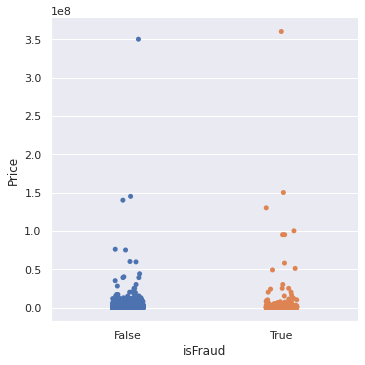

In [ ]:
sns.catplot(x="isFraud", y="Price", data=df[df['Price'].notnull()])

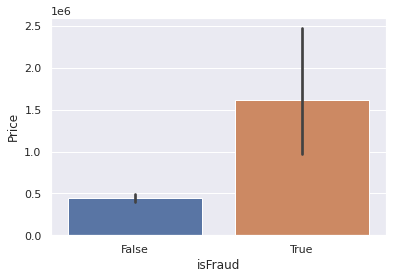

In [ ]:
sns.barplot(x="isFraud", y="Price", data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


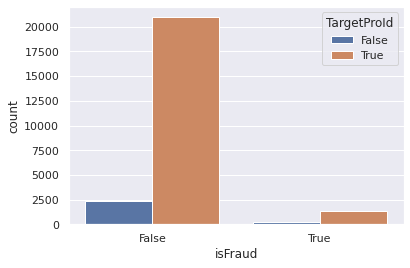

In [ ]:
ax = sns.countplot(df['isFraud'], hue=df['TargetProId'].isnull())
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


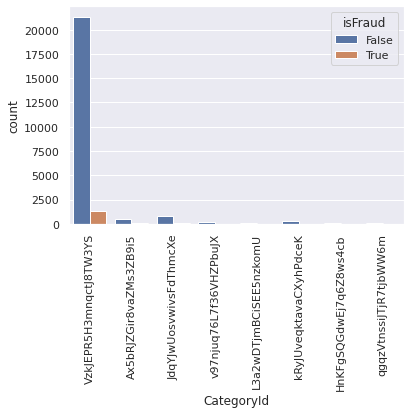

In [ ]:
ax = sns.countplot(df['CategoryId'], hue=df['isFraud'])
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


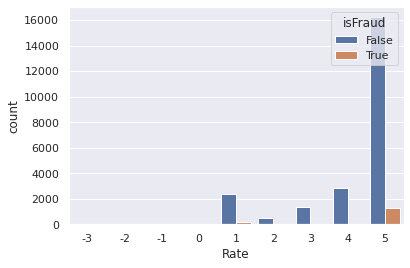

In [ ]:
ax = sns.countplot(df['Rate'], hue=df['isFraud'])
plt.show()

## Method 1. **Fastai** : A High-Level API on top of PyTorch


In [ ]:
!pip install -Uq fastai

     |████████████████████████████████| 194kB 10.9MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
from fastai.tabular.all import *

In [ ]:
df['TaskCustCreationDiff'] = df['TaskCreationTimestamp'] - df['CustCreationTimestamp']
df['TaskCustCreationDiff'].head()

0    1.700000e+08
1    1.620000e+09
2    2.075000e+10
3    1.054000e+10
4    3.210000e+09
Name: TaskCustCreationDiff, dtype: float64

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['ProId', 'CustId', 'ServiceId', 'CategoryId', 'ZoneId', 'TaskState', ],
                   cont_names = ['Rate', 'ProCreationTimestamp', 'CustCreationTimestamp', 'TaskCreationTimestamp', 'Price', 'TaskCustCreationDiff' ],
                   y_names="isFraud",
                   splits=splits)

In [ ]:
dls = to.dataloaders(bs=256)

In [ ]:
dls.show_batch()

,ProId,CustId,ServiceId,CategoryId,ZoneId,TaskState,Price_na,Rate,ProCreationTimestamp,CustCreationTimestamp,TaskCreationTimestamp,Price,TaskCustCreationDiff,isFraud
0,79W2M3frp9wMTUUiYSSSiP,YxxcYyJSwMnFoGgfrFSByh,xBBePT3C9Yb6qc2yXpgrdB,qgqzVtnssiJTjR7tjbWW6m,Exa7SPbiAcpe6Px23obGiX,Finished,False,5.0,1.570870e+12,1.574980e+12,1.575190e+12,119999.995960,2.100001e+08,False
1,sSfxB5Jfn7pwsUdj3AUDBs,iJ4YgAZbrV9Xb9viodDJpG,9xuXATNVmbKCYmvFUbcPYb,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,True,5.0,1.539750e+12,1.540110e+12,1.540200e+12,109999.994632,9.000000e+07,False
2,vZhFM8GcQLBMYeLq5CdKic,NxYKpYjt8PsFtDQFogbkCr,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,4vmCuHsVCshaWa5e5WxrNK,Finished,False,1.0,1.519820e+12,1.564850e+12,1.565040e+12,340000.001052,1.899999e+08,False
3,SgmiQmZgUtsLY72Juh7Gn9,nzZY5YNEdr35ZkWKwE7vVz,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,False,1.0,1.548760e+12,1.562360e+12,1.562560e+12,49999.986664,2.000001e+08,False
4,R8JoHeN6VXtV9YYj96yV2m,WaN7uGZqDUy8EXysqnMMJX,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,False,4.0,1.529990e+12,1.544100e+12,1.548940e+12,99999.993304,4.840000e+09,False
5,kAMRWmUCuuR8NSVDuDXxmH,53ADPzrEaWjB5hhynTg7C6,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,False,4.0,1.536090e+12,1.541750e+12,1.563170e+12,119999.995960,2.142000e+10,False
6,Lb5AHQmS7eNfVsqunpV2su,9sXCQ7uvQMsgPUVRtidkCx,dhkij8zJfVRwvmz9T8VNUL,VzkJEPR5H3mnqctJ8TW3YS,R7KfSm2xnr4p8hV44JsMtM,Finished,False,5.0,1.555690e+12,1.551490e+12,1.566740e+12,59999.987992,1.525000e+10,False
7,ung38G6iTkGcXgFZmbakUz,CAt59DGYY7cfMJkaUh7H6v,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,True,1.0,1.528190e+12,1.568890e+12,1.569130e+12,109999.994632,2.399999e+08,False
8,qv8L6yefk2guJzZn4FtGMj,YDLAnKM35Cx9TqxV59QEti,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,True,5.0,1.528990e+12,1.567610e+12,1.568300e+12,109999.994632,6.900000e+08,False
9,3hMiDjJx4Wo9NzKhpbTdR9,5mRCH6BCreLfiyATRn2YVD,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,True,5.0,1.546100e+12,1.548860e+12,1.563090e+12,109999.994632,1.423000e+10,False


In [ ]:
fastai_model = tabular_learner(dls, metrics=accuracy)

In [ ]:
fastai_model.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.275606,0.222719,0.936632,00:01


## Method 2. **Keras**: A Tensorflow API

In [ ]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
keras_df = df.copy()
keras_df.head()

,id,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,TaskState,TargetProId,isFraud,TaskCustCreationDiff
0,VkSa32MyS738HMkfk4tEfk,vqUkxUDuEmB7gHWQvcYrBn,1.552750e+12,SgcxJApdnttAvEN9865TSZ,1.565440e+12,5,1.565610e+12,362000.0,bKv8JeCDhHBCe8SnfDcv66,VzkJEPR5H3mnqctJ8TW3YS,98DpwFpuLYJtF6jajghriE,Finished,vqUkxUDuEmB7gHWQvcYrBn,False,1.700000e+08
1,FDPHLhrcjx3Gww4syg43Po,KaLEhwzZxCQ7GjPmVwBVav,1.558260e+12,EveEDVPDDDq3Ljh3bg8Exn,1.561660e+12,5,1.563280e+12,NaN,aegfi8HeWASAP6a9YkddeL,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,YvvjyjpmXxj43RJGBHPq2n,False,1.620000e+09
2,6Z7CCQoHpC8ga8KZbsgUbx,pybDYgTiCUv3Pv3WLgxKCM,1.558540e+12,mrDLWRmWuxGD7TVPAsD5X6,1.545550e+12,1,1.566300e+12,NaN,uDHVz7XXXRCkGKWRUe2jKp,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False,2.075000e+10
3,n5DKFF8SJYoP57ypvpCEg5,zqPiDV33KwrMBZoyeQXMJW,1.507730e+12,aK3MnLeQywfLYMJJNyu7i8,1.512290e+12,4,1.522830e+12,NaN,Jy7nZvUqvwDUhcAG59wPcg,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False,1.054000e+10
4,oCwEhmYhhzHkuZyqQCusFU,CR8z3ThPyzBKXFqqzemQAS,1.560860e+12,vHjzucgXFu9eA9YhuEeuk4,1.561330e+12,1,1.564540e+12,150000.0,f8o6yBmfeJiUTAmvpRCFAZ,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False,3.210000e+09


In [ ]:
cols_with_missing_values = keras_df.columns[keras_df.isna().sum() > 0]
for col in cols_with_missing_values:
    print(f"number of missing values for column {col}: {keras_df[col].isna().sum()}")
    print(f"Example values for column {col}: {keras_df[col].unique()[:5]}")
    print('-'*100)

number of missing values for column Price: 5989
Example values for column Price: [362000.     nan 150000. 180000. 390000.]
----------------------------------------------------------------------------------------------------
number of missing values for column TargetProId: 22304
Example values for column TargetProId: ['vqUkxUDuEmB7gHWQvcYrBn' 'YvvjyjpmXxj43RJGBHPq2n' nan
 'piTYfvXVuSVYwtJUjzN2k9' 'q8yHdbLDLMfoyaMfHB3Ydi']
----------------------------------------------------------------------------------------------------


For columns with missing values, we basically have three options.


1.   Remove them from the dataset.
2.   Replace them with some special value. (for example mean)
3.   Ignore the feature with missing values.

As the number of rows with missing `Price` or `TargetProId` is relatively big (roughly 25% for `Price` and 90% for 'TargetProId'), we can't drop them. Therefore we replace the missing values, with the mean of the column.

In [ ]:
keras_df['Price'] = keras_df['Price'].fillna(keras_df['Price'].mean())
keras_df['TargetProId'] = keras_df['TargetProId'].fillna('NA')

As the model will be evaluated by Rahnama College with some test dataset, we use the whole dataset as train and cross-validation set. with a ratio of 80-20.

In [ ]:
train, val = train_test_split(keras_df, test_size=0.2)
print(f"Train size: {len(train)}")
print(f"Cross-Validation size: {len(val)}")

Train size: 19884
Cross-Validation size: 4971


Now we convert the dataframe to Tensorflow.data.Dataset object, which gets two arguments as input, input features (`X`), and output labels (`Y`).
We also use `batch` method, to group the dataset in to batches, and feed the model with batches.

`prefetch` method is used to create a pipeline flow for the model.

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('isFraud')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
train_ds = df_to_dataset(train, batch_size=128)
valid_ds = df_to_dataset(val, batch_size=128)

In [ ]:
train_ds

<PrefetchDataset shapes: ({id: (None,), ProId: (None,), ProCreationTimestamp: (None,), CustId: (None,), CustCreationTimestamp: (None,), Rate: (None,), TaskCreationTimestamp: (None,), Price: (None,), ServiceId: (None,), CategoryId: (None,), ZoneId: (None,), TaskState: (None,), TargetProId: (None,), TaskCustCreationDiff: (None,)}, (None,)), types: ({id: tf.string, ProId: tf.string, ProCreationTimestamp: tf.float64, CustId: tf.string, CustCreationTimestamp: tf.float64, Rate: tf.int64, TaskCreationTimestamp: tf.float64, Price: tf.float64, ServiceId: tf.string, CategoryId: tf.string, ZoneId: tf.string, TaskState: tf.string, TargetProId: tf.string, TaskCustCreationDiff: tf.float64}, tf.bool)>

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of prices:', train_features['Price'])
print('A batch of targets:', label_batch )

Every feature: ['id', 'ProId', 'ProCreationTimestamp', 'CustId', 'CustCreationTimestamp', 'Rate', 'TaskCreationTimestamp', 'Price', 'ServiceId', 'CategoryId', 'ZoneId', 'TaskState', 'TargetProId', 'TaskCustCreationDiff']
A batch of prices: tf.Tensor(
[2.70000000e+06 5.00000000e+04 4.60000000e+05 9.80000000e+05
 5.00000000e+05 3.50000000e+05 1.00000000e+05 2.50000000e+05
 1.70000000e+05 5.00000000e+04 4.00000000e+04 1.00000000e+05
 3.50000000e+05 3.00000000e+04 1.00000000e+04 7.00000000e+04
 3.50000000e+05 5.13763772e+05 4.00000000e+04 1.40000000e+06
 4.00000000e+04 0.00000000e+00 4.00000000e+04 5.13763772e+05
 7.00000000e+04 2.00000000e+04 5.13763772e+05 1.23000000e+05
 7.00000000e+04 5.13763772e+05 1.00000000e+05 1.60000000e+05
 5.13763772e+05 5.13763772e+05 5.13763772e+05 4.00000000e+04
 8.50000000e+05 8.00000000e+04 5.00000000e+04 0.00000000e+00
 0.00000000e+00 4.50000000e+04 5.13763772e+05 4.00000000e+05
 5.13763772e+05 4.00000000e+04 1.30000000e+05 8.50000000e+04
 0.00000000e+00 9

Now it's time to create a normalization layer for the numerical features.
All this layer does is that it adjusts the data, so that it has a mean of 0, and standard deviation of 1.

Normalizing the data helps the model to train faster and better.

In [ ]:
def get_normalization_layer(name, dataset):
  normalizer = preprocessing.Normalization()

  feature_ds = dataset.map(lambda x, y: x[name])

  normalizer.adapt(feature_ds)

  return normalizer

Example output of the method above:

In [ ]:
proCreationTimestamp = train_features['ProCreationTimestamp']
layer = get_normalization_layer('ProCreationTimestamp', train_ds)
layer(proCreationTimestamp)

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[ 0.8436412 ],
       [-0.9018011 ],
       [-0.0284697 ],
       [ 0.16567308],
       [ 0.2228837 ],
       [ 1.2720907 ],
       [-2.1469777 ],
       [ 0.2496623 ],
       [ 0.9142451 ],
       [-0.17878717],
       [ 0.87650627],
       [-0.16357514],
       [-0.53724694],
       [ 1.1242062 ],
       [-0.57072616],
       [-0.2019203 ],
       [ 1.5453488 ],
       [ 0.41032586],
       [-1.1598392 ],
       [ 1.0809951 ],
       [ 0.7237558 ],
       [ 1.3755516 ],
       [-1.1598392 ],
       [-0.96509016],
       [ 0.85398734],
       [ 1.5380499 ],
       [-0.9060608 ],
       [ 0.14924058],
       [ 0.2508748 ],
       [ 0.26670104],
       [ 0.8460822 ],
       [-0.9018011 ],
       [ 0.7785255 ],
       [-2.0167382 ],
       [ 0.14194168],
       [-0.68574566],
       [ 0.38050804],
       [-1.6527982 ],
       [-0.03212314],
       [ 0.4036332 ],
       [-0.21713233],
       [ 0.9702353 ],
       [ 0.9957934 ],
    

Next, we write a method that encodes categorical features into some tokens.

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  feature_ds = dataset.map(lambda x, y: x[name])

  index.adapt(feature_ds)

  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  feature_ds = feature_ds.map(index)

  encoder.adapt(feature_ds)

  return lambda feature: encoder(index(feature))

Example output of the method above:


In [ ]:
target_pro_id_encoded = train_features['TargetProId']
layer = get_category_encoding_layer('TargetProId', train_ds, 'string')
layer(target_pro_id_encoded)

<tf.Tensor: shape=(128, 855), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)


In [ ]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['ProCreationTimestamp', 'CustCreationTimestamp', 'Rate', 'TaskCreationTimestamp', 'Price']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

Naturally, cause there is an order between `Rate` column values, (`1 < 2 < 3 < 4 < 5`), we treat it as a continuous feature.

However, as the column domain of values is small, it could also be treated as categories.

In [ ]:
# # Categorical features encoded as integers.
# rate_col = tf.keras.Input(shape=(1,), name='Rate', dtype='int64')
# encoding_layer = get_category_encoding_layer('Rate', train_ds, dtype='int64',
#                                              max_tokens=5)
# encoded_rate_col = encoding_layer(rate_col)
# all_inputs.append(rate_col)
# encoded_features.append(encoded_rate_col)

In [ ]:
# Categorical features encoded as string.
categorical_cols = ['ProId', 'CustId', 'ServiceId', 'CategoryId', 'ZoneId', 'TaskState', ]
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
keras_model = tf.keras.Model(all_inputs, output)
keras_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

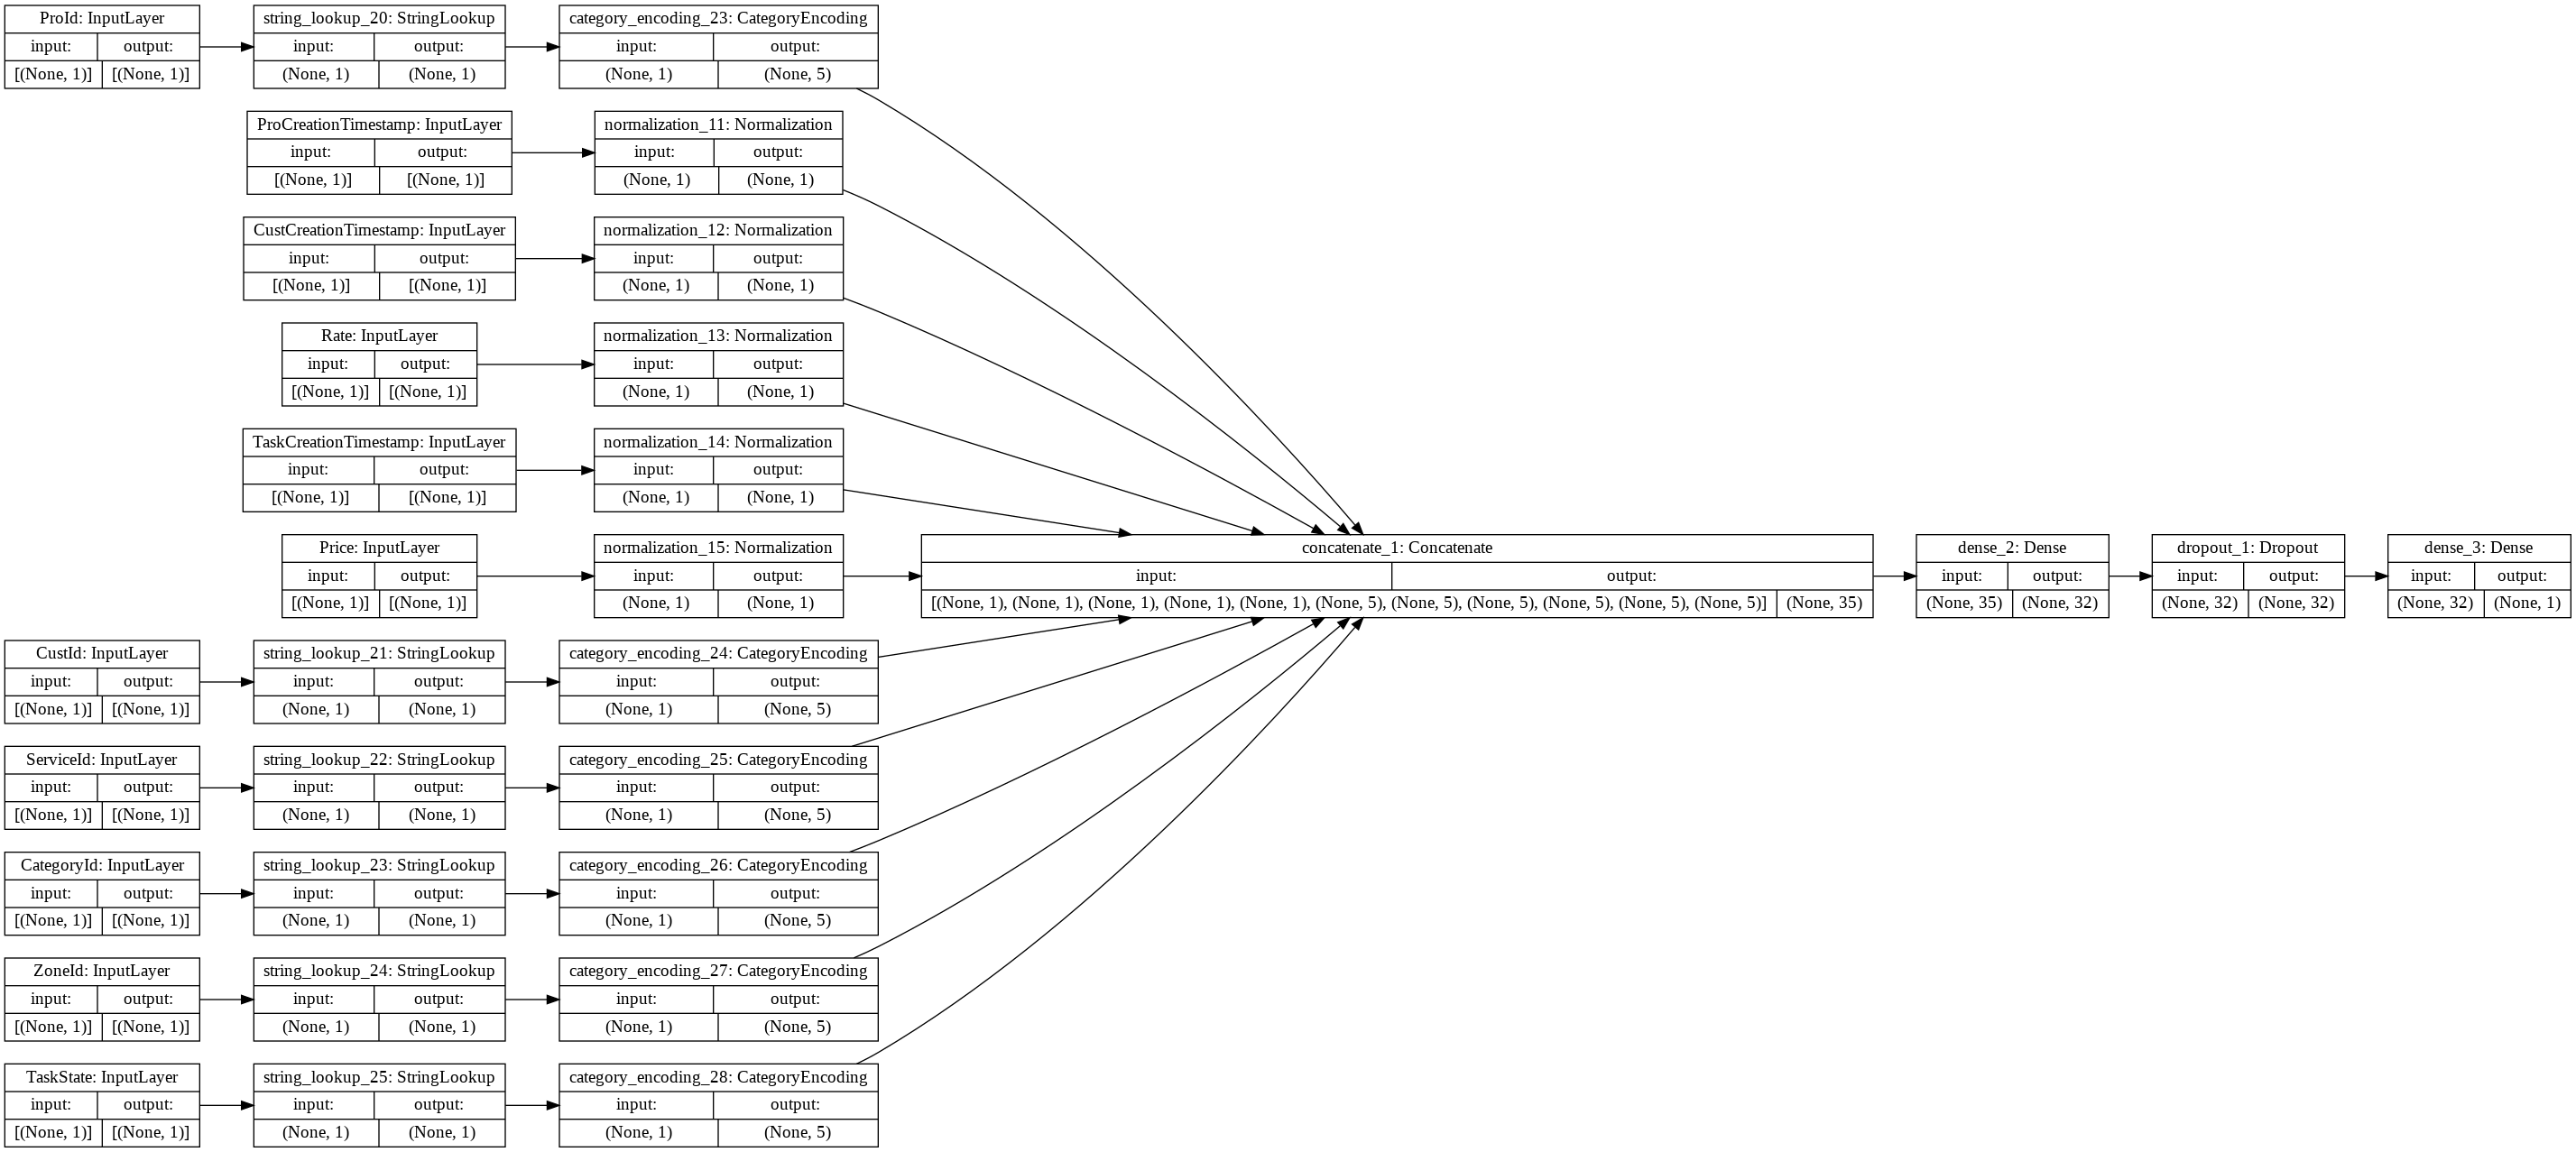

In [ ]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
keras_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id', 'TargetProId', 'TaskCustCreationDiff'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


78/78 [==============================] - 2s 16ms/step - loss: 0.5142 - accuracy: 0.9081 - val_loss: 0.2479 - val_accuracy: 0.9390
Epoch 2/10
78/78 [==============================] - 1s 10ms/step - loss: 0.2639 - accuracy: 0.9396 - val_loss: 0.2239 - val_accuracy: 0.9390
Epoch 3/10
78/78 [==============================] - 1s 10ms/step - loss: 0.2453 - accuracy: 0.9387 - val_loss: 0.2215 - val_accuracy: 0.9390
Epoch 4/10
78/78 [==============================] - 1s 10ms/step - loss: 0.2469 - accuracy: 0.9373 - val_loss: 0.2207 - val_accuracy: 0.9390
Epoch 5/10
78/78 [==============================] - 1s 10ms/step - loss: 0.2441 - accuracy: 0.9386 - val_loss: 0.2199 - val_accuracy: 0.9390
Epoch 6/10
78/78 [==============================] - 1s 10ms/step - loss: 0.2367 - accuracy: 0.9400 - val_loss: 0.2195 - val_accuracy: 0.9388
Epoch 7/10
78/78 [==============================] - 1s 10ms/step - loss: 0.2403 - accuracy: 0.9361 - val_loss: 0.2195 - val_accuracy: 0.9388
Epoch 8/10
78/78 [======

## Conclusion
Both models, although with different architechtures, gave the same results in terms of accuracy.

In [ ]:
keras_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ProId (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
CustId (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
ServiceId (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
CategoryId (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
fastai_model.summary()

TabularModel (Input shape: 256 x torch.Size([256, 6]))
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 170           
Embedding                                 707540     True      
____________________________________________________________________________
                     256 x 402           
Embedding                                 7752570    True      
____________________________________________________________________________
                     256 x 32            
Embedding                                 6848       True      
____________________________________________________________________________
                     256 x 5             
Embedding                                 45         True      
____________________________________________________________________________
                     256 x 13            
Embedding                                 572        True      
___________________________________________